Exploring Gaussian Mixture Models for detection of clouds. One thing that stands out in some thermal datasets is that, there are regions of extremely loe **apparent** surface temperatures which are problematic. They definitely seem to be clouds which are skewing temperatures to extremely low values. Take an example of this case:

<p align="center">
  <img src="assets/phase2_thermal1_exploration.png" width="600" alt="File Handling Flow">
</p>

Temperatures in the range of -20 degrees celsius are definitely clouds and cannot be considered for anomaly detection. The question is then, how to identify these pixels and mask them so that downstream algorithms donot consider them at all.


In [1]:
import pathlib
import sys

# Register the parent directory as a path to look for modules
notebook_dir = pathlib.Path().resolve()
parent_dir = notebook_dir.parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from app.models.units.surface_temperature import Temperature
from app.utils.data_transformations.l2sp_dn_to_temperature_transformer import Lc09L2spStTransformer
from app.templates.template_mappings import TEMPLATE_MAPPINGS, TemplateIdentifier
from app.models.file_processing.sources import FileSourceConfig
from app.utils.files.tif_helper import TIFHelper
from app.utils.image_transformation.image_cube_operations import CubeRepresentation, ImageCubeOperations
import numpy as np
from sklearn.mixture import GaussianMixture
from app.statistical_models.b10_adaptive_cloud_masker import B10AdaptiveCloudMasker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [7]:
# Load in the datasets first
file_source_config = FileSourceConfig(
    source_path="../tests/test_payloads/phase_2/Set-1/Thermal Anomaly Datasets/LC09_L2SP_141045_20250604_20250605_02_T1_ST_B10.TIF"
)

# Create the helper
helper = TIFHelper(
    file_source_config=file_source_config,
    template=TEMPLATE_MAPPINGS.get(TemplateIdentifier.LANDSAT_THERMAL)
)

# Access the bands
raw_data = helper.extract_specific_bands(
    bands = [1],
    masking_needed=True,
    mode="specific"
)

# convert to temperatures in degree celsius
converter = Lc09L2spStTransformer()
converted_data = converter.transform(
    input_data=raw_data,
    unit= Temperature.CELSIUS
)

# At this point we have fully converted data in Celsius

In [3]:
masker = B10AdaptiveCloudMasker()
masker.configure(sampling_ratio=0.1)
masker.train(input_cube=converted_data)
cloud_masks = masker.predict(input_cube=converted_data)

Masked Array
(40711448, 1)
[ 5.70057964 30.2351265  36.49352264 42.5639267  45.11376953]
24.49352264404297
[0 1]


In [8]:
cloud_masks.cloud_mask.sum()

np.int64(1879817)

Using device: mps


Text(0.5, 1.0, 'Predicted Cloud Cover')

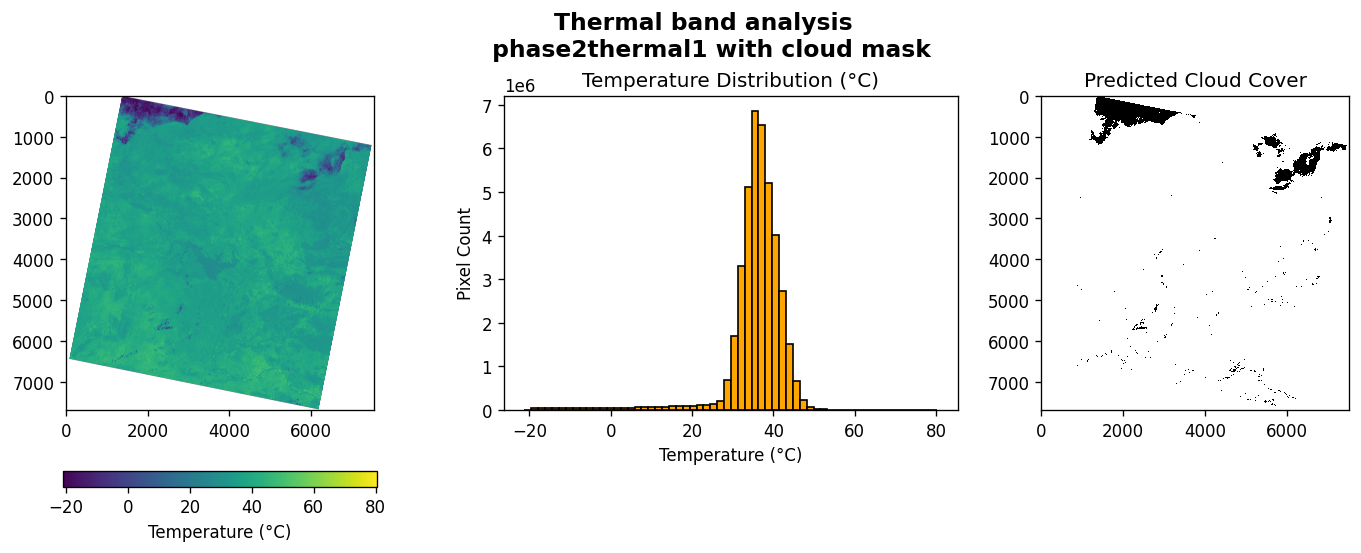

In [9]:
from mpmath import convert


fig, axes = plt.subplots(
    1,
    3,
    figsize=(4 * 3, 4.5 * 1),
    constrained_layout=True,
    dpi=120,
)

image_cube_transformer = ImageCubeOperations()
transformed_bands = image_cube_transformer.convert_cube(
    cube = converted_data,
    from_format = CubeRepresentation.BSQ,
    to_format=CubeRepresentation.BIP,
    output_form="numpy"
)
transformed_masks = image_cube_transformer.convert_cube(
    cube = cloud_masks.cloud_mask,
    from_format = CubeRepresentation.BSQ,
    to_format=CubeRepresentation.BIP,
    output_form="numpy"
)
fig.suptitle(
            f"Thermal band analysis \n phase2thermal1 with cloud mask",
            fontsize=14,
            fontweight="bold",
        )
im = axes[0].imshow(
    transformed_bands,  # Show the first channel/band in Celsius
    cmap="viridis"
)
cbar = fig.colorbar(
    im,
    ax=axes[0],
    orientation="horizontal",
    fraction=0.05,
    pad=0.02,
)
compressed_data = transformed_bands.compressed()

cbar.set_label("Temperature (°C)", fontsize=10)

axes[1].hist(
    compressed_data,
    bins=60,
    color="orange",
    edgecolor="black"
)
axes[1].set_title("Temperature Distribution (°C)")
axes[1].set_xlabel("Temperature (°C)")
axes[1].set_ylabel("Pixel Count")

bw_map = ListedColormap(['white', 'black'])
axes[2].imshow(transformed_masks, cmap=bw_map, vmin=0, vmax=1, interpolation='nearest')
axes[2].set_title("Predicted Cloud Cover")


In [11]:
cloud_masks

AdaptiveCloudMaskerResponse(cloud_mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]],
      shape=(1, 7721, 7571)), n_comp=5, model=GaussianMixture(means_init=array([[-10.        ],
       [  5.        ],
       [ 25.82246399],
       [ 30.30690575],
       [ 32.36455536]]),
                n_components=5, random_state=42), anchors=array([[-10.        ],
       [  5.        ],
       [ 25.82246399],
       [ 30.30690575],
       [ 32.36455536]]))

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = [
    '#FFFFFF',  
    '#377eb8',  
    '#4daf4a',  
    '#984ea3', 
    '#ff7f00',  
    '#e41a1c'
]
cmap_cloud = ListedColormap(colors)

# Transform the image
cube_transformer = ImageCubeOperations()
final_cube = cube_transformer.convert_cube(
    cube = label_grid,
    from_format = CubeRepresentation.BSQ,
    to_format = CubeRepresentation.BIP
)

plt.figure(figsize=(4,4.5))
plt.imshow(final_cube, 
           cmap=cmap_cloud, 
           vmin=-1, 
           vmax=4, 
           interpolation='nearest')


Using device: mps


NameError: name 'label_grid' is not defined

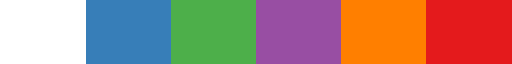

In [ ]:
cmap_cloud